In [2]:
import osmnx as ox
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from datetime import datetime, timedelta

In [ ]:
def download_and_save_graph(area_of_interest, north, east, south, west, filename):
	"""
	Downloads a map as a graph object for a specified area and saves it to a file.

	Parameters:
	area_of_interest (str): The area of interest to download the map for.
	north (float): Northern boundary of the bounding box.
	east (float): Eastern boundary of the bounding box.
	south (float): Southern boundary of the bounding box.
	west (float): Western boundary of the bounding box.
	filename (str): The name of the file to save the graph to.
	"""
	# Configure OSMnx
	# ox.config(use_cache=True, log_console=True)

	# Define the area in Atlanta (downtown area)
	state = ox.geocode_to_gdf(area_of_interest)
	# roads_filter = '["highway"~"motorway|trunk|primary|secondary|tertiary|residential"]'
	roads_filter = '["highway"~"motorway|truck|primary|secondary"]'
	# Downloading the map as a graph object
	G = ox.graph_from_bbox(bbox=tuple([west, south, east, north]), retain_all=False, custom_filter=roads_filter)
	print(G.nodes(data=True))

	
	print(G.nodes(data=True))
	
	G = ox.consolidate_intersections(ox.project_graph(G.copy()), tolerance=200)
	print(G.nodes(data=True))

	
	# print("Current CRS:", G.graph["crs"])
	G = ox.project_graph(G, to_crs="EPSG:4326")
	print(G.nodes(data=True))



	return G
    


In [23]:
aoI = "College Park, Maryland, US"
north, east, south, west = 38.99524, -76.92288, 38.98260, -76.94831
graph_name = "college_park.pickle"
G = download_and_save_graph(aoI, north, east, south, west, graph_name)

[(50527315, {'y': 38.9884905, 'x': -76.9350973, 'highway': 'traffic_signals', 'street_count': 4}), (50528587, {'y': 38.9885308, 'x': -76.9352816, 'highway': 'traffic_signals', 'street_count': 3}), (50528589, {'y': 38.988676, 'x': -76.935187, 'highway': 'traffic_signals', 'street_count': 3}), (50691254, {'y': 38.9885397, 'x': -76.936644, 'street_count': 1}), (50855193, {'y': 38.9881607, 'x': -76.9341718, 'street_count': 3}), (250764171, {'y': 38.9875728, 'x': -76.9358911, 'street_count': 3}), (1008887783, {'y': 38.9883204, 'x': -76.9374174, 'street_count': 1}), (1008887828, {'y': 38.9883727, 'x': -76.9365314, 'street_count': 3}), (1350969004, {'y': 38.988619, 'x': -76.9350185, 'highway': 'traffic_signals', 'street_count': 4}), (5080867316, {'y': 38.987937, 'x': -76.9338562, 'street_count': 3}), (5863120455, {'y': 38.9876084, 'x': -76.9335392, 'street_count': 3})]
[(50527315, {'y': 38.9884905, 'x': -76.9350973, 'highway': 'traffic_signals', 'street_count': 4}), (50528587, {'y': 38.988530

In [24]:
print(G.nodes(data=True))

[(0, {'osmid_original': [50527315, 1350969004, 50528587, 50528589], 'x': np.float64(-76.93514822421896), 'y': np.float64(38.98857911478658), 'cluster': np.float64(0.0), 'highway': 'traffic_signals', 'street_count': np.int64(2)}), (1, {'osmid_original': 50855193, 'x': np.float64(-76.9341718), 'y': np.float64(38.988160699999995), 'street_count': np.int64(3)}), (2, {'osmid_original': 250764171, 'x': np.float64(-76.9358911), 'y': np.float64(38.9875728), 'street_count': np.int64(3)}), (4, {'osmid_original': 5080867316, 'x': np.float64(-76.9338562), 'y': np.float64(38.987936999999995), 'street_count': np.int64(3)}), (3, {'osmid_original': 1008887828, 'x': np.float64(-76.9365314), 'y': np.float64(38.9883727), 'street_count': np.int64(3)}), (5, {'osmid_original': 5863120455, 'x': np.float64(-76.93353920000001), 'y': np.float64(38.987608400000006), 'street_count': np.int64(3)})]


In [ ]:
filename = 'graph_files/college_park.pickle'
with open(filename, 'rb') as f:
    G = pickle.load(f)


In [8]:
import osmnx as ox
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from datetime import datetime, timedelta

def load_and_visualize_graph(filename):
    """
    Loads a saved graph from a file and visualizes it as an undirected graph.
    
    Parameters:
    filename (str): The name of the file to load the graph from.
    """
    # Load the graph
    with open(filename, 'rb') as f:
        G = pickle.load(f)
    
    # Extract latitudes and longitudes
    # nodes_dict = {id: (n_data['y'], n_data['x']) for id, n_data in G.nodes(data=True)}
    nodes_dict = {}
    check_list = []
    for id, n_data in G.nodes(data=True):
        nodes_dict[id] = [n_data['y'], n_data['x'], []]
        for n1, n2, _ in G.edges(data=True):
            if id == n1:
                nodes_dict[id][2].append((n2))
            if id == n2:
                nodes_dict[id][2].append((n1))
            if id == 0:
                if id == n1:
                    check_list.append(n2)
                if id == n2:
                    check_list.append(n1)
        nodes_dict[id][2] = list(set(nodes_dict[id][2]))

    G = ox.project_graph(G)

    # Plot the graph
    fig, ax = ox.plot_graph(G, node_size=30, node_color="r", edge_linewidth=0.5)
    plt.show()

    return nodes_dict


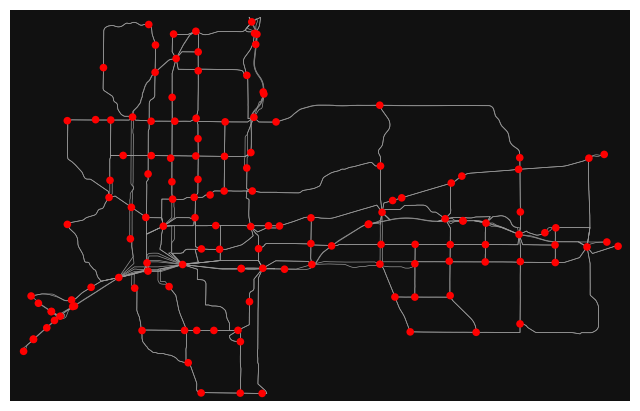

In [13]:
nodes_dict = load_and_visualize_graph(filename="graph_files/washington.pickle")

In [20]:
def extract_weather_data(nodes_dict, start_date, end_date, timezone="America/New_York"):
    """
    Extracts temperature, precipitation, snowfall, relative humidity, and dewpoint data from Open-Meteo for given locations.
    
    Parameters:
    nodes_dict (dict): Dictionary of node IDs with their corresponding latitudes and longitudes.
    start_date (str): The start date for the weather data in YYYY-MM-DD format.
    end_date (str): The end date for the weather data in YYYY-MM-DD format.
    timezone (str): The timezone for the weather data.
    
    Returns:
    pd.DataFrame: DataFrame containing the weather data for all locations.
    """
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    # API parameters
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "daily": [
            "temperature_2m_max",       # index 0
            "temperature_2m_min",       # index 1
            "temperature_2m_mean",      # index 2
            "precipitation_sum",        # index 5
            "snowfall_sum",             # index 6
            "relative_humidity_2m_max",                 # index 7
            "relative_humidity_2m_min",      # index 8
            "dewpoint_2m_max",  # index 9
            "dewpoint_2m_min"
        ],
        "timezone": timezone,
        "start_date": start_date,
        "end_date": end_date
    }

    all_data = []

    for k, [lat, lon, edge_list] in nodes_dict.items():
        params["latitude"] = lat
        params["longitude"] = lon

        responses = openmeteo.weather_api(url, params=params)
        response = responses[0]

        daily = response.Daily()
        # Extract daily variables using updated indices
        temperature_max = daily.Variables(0).ValuesAsNumpy()
        temperature_min = daily.Variables(1).ValuesAsNumpy()
        temperature_mean = daily.Variables(2).ValuesAsNumpy()
        precipitation_sum = daily.Variables(3).ValuesAsNumpy()
        snowfall_sum = daily.Variables(4).ValuesAsNumpy()
        relative_humidity_max = daily.Variables(5).ValuesAsNumpy()
        relative_humidity_min = daily.Variables(6).ValuesAsNumpy()
        dewpoint_max = daily.Variables(7).ValuesAsNumpy()
        dewpoint_min = daily.Variables(8).ValuesAsNumpy()

        num_days = len(temperature_max)
        edge_list_repeated = [edge_list] * num_days
      

        daily_data = {
            "node_id": k,
            "date": pd.date_range(
                start=pd.to_datetime(daily.Time(), unit="s", utc=True),
                end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(days=1),
                inclusive="left"
            ),
            "edge_list": edge_list_repeated,
            "latitude": lat,
            "longitude": lon,
            "temperature_max": temperature_max,
            "temperature_min": temperature_min,
            "temperature_mean": temperature_mean,
            "precipitation_sum": precipitation_sum,
            "snowfall_sum": snowfall_sum,
            "relative_humidity_max": relative_humidity_max,
            "relative_humidity_min": relative_humidity_min,
            "dewpoint_max": dewpoint_max,
            "dewpoint_min": dewpoint_min,
        }
        df = pd.DataFrame(data=daily_data)
        all_data.append(df)

    # Combine all dataframes
    result_df = pd.concat(all_data, ignore_index=True)
    return result_df

In [ ]:
start_date = "2025-01-01"
end_date = "2025-01-08"
weather_data = extract_weather_data(nodes_dict, start_date, end_date)


PermissionError: [Errno 13] Permission denied: 'graph_data/washington_jan2025.csv'

In [22]:
weather_data.to_csv("washington_jan2025.csv", index=False)